In [48]:
import sys
# Delete all global variables when re-running the notebook.
this = sys.modules[__name__] # type: ignore
for n in dir():
    if n in ['this', 'was_mounted']: continue
    if n[0]!='_': delattr(this, n)


try:
    was_mounted = was_mounted
except:
    was_mounted = False


import os
if  os.getenv("COLAB_RELEASE_TAG"):
  is_running_on_colab = True

else:
  is_running_on_colab = False

if is_running_on_colab:
  packages_to_install = ['pandas==2.1.3','neurokit2', 'wfdb']

  for package in packages_to_install:
    os.system(f'pip install {package}')
  from google.colab import drive, files
  code_directory = './gdrive/MyDrive/TCC/ectopic_beats_detection'
  if not was_mounted:
      drive.mount('/content/gdrive')
  was_mounted = True
  if not os.path.samefile(os.getcwd(),code_directory):
    os.chdir(code_directory)


import gc
import glob
import sys
from datetime import datetime
from multiprocessing import Pool, cpu_count
from os.path import join
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pyarrow as pa
import torch
import torch.nn as nn
from numba import njit
from torch import flatten
from torch.nn import Conv2d, Linear, LogSoftmax, MaxPool2d, Module, ReLU, LocalResponseNorm
from torchvision import transforms
from torchshape import tensorshape

from globals import *
from utils import load_df_multi_analysis, load_record, show_image



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)



@njit(cache = True, nogil=True)
def sig_2_pic(signal,height, width,scale):
    samples = signal.shape[0]
    scale_image = (height-10)
    offset = 5
    new_image = np.ones((height, width), dtype=np.uint8)


    x_array = np.arange(0, samples, 1,dtype=np.int32)*(width)//(samples)
    y_array = (scale*scale_image*((signal - signal.min()) / (signal.max() - signal.min()))).astype(np.int32) + offset

    for idx in range(x_array.shape[0] - 1):
        x0, y0, x1, y1 =x_array[idx], y_array[idx], x_array[idx+1], y_array[idx+1]

        ############### Bresenham algorithm ###############
        dx = x1 - x0
        dy = y1 - y0

        xsign = 1 if dx > 0 else -1
        ysign = 1 if dy > 0 else -1

        dx = abs(dx)
        dy = abs(dy)

        if dx > dy:
            xx, xy, yx, yy = xsign, 0, 0, ysign
        else:
            dx, dy = dy, dx
            xx, xy, yx, yy = 0, ysign, xsign, 0

        D = 2*dy - dx
        y = 0

        for x in range(dx + 1):
            xc, yc =  x0 + x*xx + y*yx, y0 + x*xy + y*yy
            new_image[height-1 - yc,xc] = 0
            if D >= 0:
                y += 1
                D -= 2*dx
            D += 2*dy
        ###################################################
        
    return new_image


old_vars = dir()

df_record_lead_ann = pd.read_parquet(join(dataframes_directory, 'df_record_lead_ann.parquet'))
df_lead_ann_summery =  pd.read_parquet(join(dataframes_directory, 'df_lead_ann_summery.parquet'))
df_ann_summery = pd.read_parquet(join(dataframes_directory, 'df_ann_summery.parquet'))
df_code_description = pd.read_parquet(join(dataframes_directory, 'df_code_description.parquet'))

df_multi_analysis = load_df_multi_analysis(glob.glob(join(dataframes_directory, 'dict_multi_analysis*.pickle')))

In [49]:
list_record_track =  []

for idx, row in df_record_lead_ann.iterrows():
    if row['upper_signal'] == 'MLII':
        signal_track = 0
    elif row['lower_signal'] == 'MLII':
        signal_track = 1
    else:
        continue
    list_record_track.append({'record': row['record'], 'track': signal_track})


In [50]:
derised_anns = LIST_BEATS_2
discard_time = 100
df = pd.DataFrame({'record': pd.Series(dtype=np.uint8),
                   'ecg_beat_indexes': pd.Series(dtype=INDEX_TYPE),
                   'ecg_beat_indexes': pd.Series(dtype=ANN_TYPE)})

dict_records_info = {}
for item in list_record_track:
    record_num = item['record']
    track_num = item['track']

    record, ann = load_record(record_num)

    ecg = record.p_signal[:, 0] #+ record.p_signal[:, 1] # type: ignore
 
    ecg_beat_indexes = pd.Series(ann.sample, dtype=INDEX_TYPE)
    ecg_beat_anns = pd.Series(ann.symbol, dtype=ANN_TYPE)

     # Mask for time window and derised annotations
    mask_derised_ann = ecg_beat_anns.isin(derised_anns)

    ecg_beat_indexes = ecg_beat_indexes[mask_derised_ann].reset_index(drop=True)
    ecg_beat_anns = ecg_beat_anns[mask_derised_ann].reset_index(drop=True)

    aux_df = pd.DataFrame(
    {
        'record': record_num * np.ones(ecg_beat_indexes.shape[0]-2, dtype=np.uint8),
        'ecg_beat_indexes': ecg_beat_indexes.iloc[1:-1],
        'ecg_beat_anns': ecg_beat_anns.iloc[1:-1]
    }
    )

    df = pd.concat([df, aux_df], ignore_index=True, axis=0)

    dict_records_info[record_num] = {
    'ecg': ecg,
    'ecg_beat_indexes': ecg_beat_indexes,
    'ecg_beat_anns': ecg_beat_anns
    }

dict_df_beat_type = {}
for beat_type in derised_anns:
    # Shuffle the dataframe and save it in a dictionary
    dict_df_beat_type[beat_type] = {
        'df':df[df['ecg_beat_anns'] == beat_type].sample(frac=1).reset_index(drop=True), 
        'idx': 0
        }


beat_type_quants = df.ecg_beat_anns.value_counts()


for v in dir():
    if v not in old_vars + ['dict_df_beat_type', 'list_record_track', 'dict_records_info', 'old_vars', 'derised_anns', 'beat_type_quants']:
        #print(v)
        delattr(this, v)
gc.collect()

1962

In [101]:
# Implement Alexnet architecture in Pytorch

class AlexNet(Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
            Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
            Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            ReLU(inplace=True),
            Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            ReLU(inplace=True),
            Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
        )

        image_size = (32, 1, 128, 128)
        out_size = tensorshape(self.features,image_size)
        print(out_size)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            Linear(256 * 3 * 3, 4096),
            ReLU(inplace=True),
            Linear(4096, 4096),
            ReLU(inplace=True),
            Linear(4096, num_classes),
            #LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = flatten(x, 1)
        x = self.classifier(x)
        return x

In [136]:
dict_quant_per_batch = {
    'N': 10,
    'L': 5,
    'R': 4,
    'V': 4,
    '/': 4,
    'A': 2,
    '!': 2,
    'E': 1,
 }


dict_beat_to_int = {
    'N': 0,
    'L': 1,
    'R': 2,
    'V': 3,
    '/': 4,
    'A': 5,
    '!': 6,
    'E': 7,
}

dict_beat_acronyms = {
    'N': 'NOR',
    'L': 'LBB',
    'R': 'RBB',
    'V': 'PVC',
    '/' : 'PAB',
    'A': 'APC',
    '!' : 'VFW',
    'E': 'VEB',
    
} 


quant_per_batch = sum(dict_quant_per_batch.values())

print(f'{quant_per_batch} beats per batch')


height = 128
width = 128

print(f'height: {height}, width: {width}')
np.random.seed(42)

x_np = np.zeros((quant_per_batch, height, width), dtype=np.uint8)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = AlexNet(num_classes=len(dict_beat_to_int))
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


loss_fn = nn.CrossEntropyLoss()


for epoch in range(10_000):
    beat_idx = 0
    list_beat_type =[]
    for beat_type in derised_anns:
        for i in range(dict_quant_per_batch[beat_type]): 
            df = dict_df_beat_type[beat_type]['df']
            shape = df.shape[0] 
            idx = dict_df_beat_type[beat_type]['idx']
            if idx == shape:
                dict_df_beat_type[beat_type]['idx'] = idx = 0
            else:
                dict_df_beat_type[beat_type]['idx'] = idx + 1
            
            ecg_beat_idx = df.iloc[idx]['ecg_beat_indexes']
            ecg_beat_ann = df.iloc[idx]['ecg_beat_anns']
            record_num = df.iloc[idx]['record']

            ecg_beat_indexes = dict_records_info[record_num]['ecg_beat_indexes']
            ecg_beat_anns = dict_records_info[record_num]['ecg_beat_anns']
            ecg = dict_records_info[record_num]['ecg']
            
            ann_beat_index = ecg_beat_indexes[ecg_beat_indexes == ecg_beat_idx].index[0]
            beat_type = ecg_beat_anns[ann_beat_index]
        
            middle = ecg_beat_indexes[ann_beat_index]
            start = ecg_beat_indexes[ann_beat_index -1]
            end = ecg_beat_indexes[ann_beat_index + 1] 

            #beat_pic = ecg[middle-50:middle+50]
            beat_pic = sig_2_pic(
                signal = ecg[start+20+np.random.randint(10):end-20-np.random.randint(10)],
                height = height,
                width = width,
                scale = np.random.randint(70,100)/100
                )
            x_np[beat_idx] = beat_pic
            beat_idx += 1
            list_beat_type.append(dict_beat_to_int[beat_type])

    #[N, C, W, H] = NumSamples x NumChannels x Width x Height 
    x_train = torch.from_numpy(x_np.reshape(quant_per_batch,1, height, width)).float()
    y_train_labels = torch.tensor(list_beat_type, dtype=torch.long)
    y_train_onehot = nn.functional.one_hot(y_train_labels, num_classes=len(dict_beat_to_int)).float()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_train)
    # Compute loss
    loss =  loss_fn(y_pred, y_train_onehot)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch % 10 == 0):
        y_pred_labels = y_pred.argmax(dim=1)
        # Compute metrics
        # True positive
        tp = (y_pred_labels == y_train_labels).sum().item()
        # False positive
        fp = (y_pred_labels != y_train_labels).sum().item()
        
        # Accuracy
        acc = 100 * tp / (tp + fp)
        print(f'Epoch {epoch}: loss: {loss.item():.2f}, acc: {acc:.2f}%')

32 beats per batch
height: 128, width: 128
(32, 256, 3, 3)
Epoch 0: loss: 2.15, acc: 9.38%
Epoch 10: loss: 1.64, acc: 46.88%
Epoch 20: loss: 1.83, acc: 34.38%
Epoch 30: loss: 1.51, acc: 50.00%
Epoch 40: loss: 1.19, acc: 56.25%
Epoch 50: loss: 1.07, acc: 53.12%
Epoch 60: loss: 1.02, acc: 53.12%
Epoch 70: loss: 1.27, acc: 53.12%
Epoch 80: loss: 1.14, acc: 53.12%
Epoch 90: loss: 1.15, acc: 62.50%
Epoch 100: loss: 0.81, acc: 71.88%
Epoch 110: loss: 0.60, acc: 71.88%
Epoch 120: loss: 1.01, acc: 65.62%
Epoch 130: loss: 1.17, acc: 59.38%
Epoch 140: loss: 0.58, acc: 71.88%
Epoch 150: loss: 0.70, acc: 65.62%
Epoch 160: loss: 0.69, acc: 65.62%
Epoch 170: loss: 0.59, acc: 78.12%
Epoch 180: loss: 0.56, acc: 78.12%
Epoch 190: loss: 0.55, acc: 87.50%
Epoch 200: loss: 0.48, acc: 84.38%
Epoch 210: loss: 0.89, acc: 71.88%
Epoch 220: loss: 0.36, acc: 87.50%
Epoch 230: loss: 0.68, acc: 78.12%
Epoch 240: loss: 0.32, acc: 90.62%
Epoch 250: loss: 0.23, acc: 90.62%


In [135]:
y_pred_labels = y_pred.argmax(dim=1)
# Compute metrics
# True positive
tp = (y_pred_labels == y_train_labels).sum().item()
# False positive
fp = (y_pred_labels != y_train_labels).sum().item()

# Accuracy
acc = 100 * tp / (tp + fp)
print(f'Accuracy: {acc:.2f}%')

Accuracy: 50.00%


In [132]:

with torch.inference_mode():
    y_pred = model(x_train)
    y_pred_labels = y_pred.argmax(dim=1)
    # Compute metrics
    # True positive
    tp = (y_pred_labels == y_train_labels).sum().item()
    # False positive
    fp = (y_pred_labels != y_train_labels).sum().item()
    
    # Accuracy
    acc = 100 * tp / (tp + fp)
    print(f'Accuracy: {acc:.2f}%')

Accuracy: 31.25%


In [131]:
tp

10

In [90]:
(y_pred.argmax(dim=1) == y_train).sum().item() / quant_per_batch

0.15625

(32, 256, 3, 3)


In [ ]:
out_data

tensor([[-2.0949, -2.0808, -2.0772, -2.0789, -2.0764, -2.0701, -2.0762, -2.0812],
        [-2.0946, -2.0810, -2.0771, -2.0790, -2.0762, -2.0701, -2.0763, -2.0813],
        [-2.0945, -2.0810, -2.0777, -2.0786, -2.0763, -2.0701, -2.0763, -2.0812],
        [-2.0945, -2.0810, -2.0773, -2.0789, -2.0764, -2.0700, -2.0764, -2.0811],
        [-2.0948, -2.0808, -2.0773, -2.0792, -2.0764, -2.0699, -2.0763, -2.0809],
        [-2.0947, -2.0810, -2.0775, -2.0789, -2.0762, -2.0700, -2.0762, -2.0812],
        [-2.0948, -2.0809, -2.0771, -2.0788, -2.0764, -2.0701, -2.0764, -2.0812],
        [-2.0947, -2.0809, -2.0774, -2.0789, -2.0762, -2.0701, -2.0761, -2.0815],
        [-2.0943, -2.0811, -2.0773, -2.0789, -2.0761, -2.0701, -2.0764, -2.0816],
        [-2.0943, -2.0809, -2.0777, -2.0789, -2.0761, -2.0701, -2.0763, -2.0813],
        [-2.0942, -2.0809, -2.0776, -2.0788, -2.0764, -2.0701, -2.0761, -2.0816],
        [-2.0942, -2.0810, -2.0779, -2.0790, -2.0763, -2.0700, -2.0760, -2.0812],
        [-2.0942

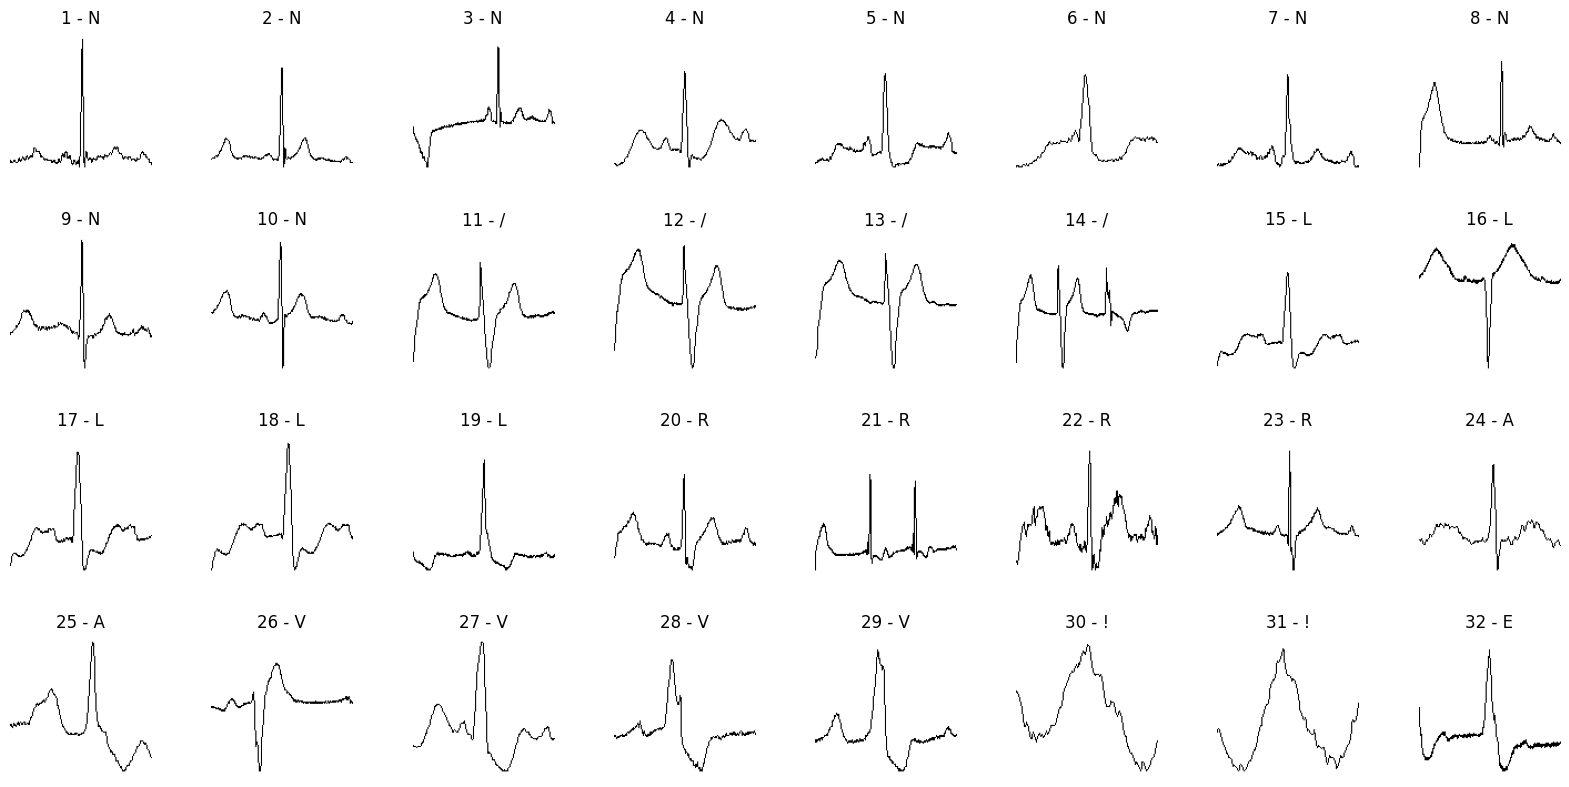

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(20., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.6,  # pad between axes in inch.
                 )

for j in range(quant_per_batch):
    ax = grid[j]
    show_image(x_np[j], axis= ax)
    ax.set_title(f'{j+1} - {list_beat_type[j]}')

plt.savefig(os.path.join(figures_directory, 'jun_2018/batch_example.png'))